В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [160]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, roc_auc_score, r2_score, mean_squared_error
import operator
from sklearn.preprocessing import PolynomialFeatures

onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = MinMaxScaler()

def gradient_descent(X_train, y_train, X_val, y_val, learning_rate, n_iterations):
    m = len(y_train)
    theta = np.random.randn(X_train.shape[1], 1)
    learning_curve_train = []
    learning_curve_val = []
    for iteration in range(n_iterations):
        gradients = 2/m * X_train.T.dot(X_train.dot(theta) - y_train)
        theta = theta - learning_rate * gradients
        y_pred = X_train.dot(theta)
        y_pred_val = X_val.dot(theta)
        train_error = mean_squared_error(y_train, y_pred, squared=False)
        val_error = mean_squared_error(y_val, y_pred_val, squared=False)
        learning_curve_train.append(train_error)
        learning_curve_val.append(val_error)
    print('Train RMSE: ', train_error)
    print('Test RMSE: ', val_error)
    return theta, learning_curve_train, learning_curve_val


def plot_learning_curve(n_iterations, learning_curve_train, learning_curve_val):
  plt.plot(range(n_iterations), learning_curve_train, 'r-', label='Training error')
  plt.plot(range(n_iterations), learning_curve_val, 'g-', label='Validation error')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Mean Squared Error')
  plt.title('Learning Curve (Gradient Descent)')
  plt.legend(loc='best')
  plt.grid()
  plt.show()


def plot_model(theta, X_train, y_train, X_val, y_val):
    plt.scatter(X_train[:, 1], y_train, color='blue', label='Train Data')
    plt.scatter(X_val[:, 1], y_val, color='orange', label='Val Data')

    # Combining X_train and X_val for plotting
    X_combined = np.concatenate((X_train, X_val), axis=0)
    X_combined_sorted_indices = np.argsort(X_combined[:, 1])
    X_combined_sorted = X_combined[X_combined_sorted_indices]

    # Making predictions with the sorted combined data
    y_pred_sorted = X_combined_sorted.dot(theta)

    plt.plot(X_combined_sorted[:, 1], y_pred_sorted, color='red', label='Model')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Model Fit')
    plt.legend()
    plt.show()

Numeric columns: Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')
Categorical columns: Index(['Geography', 'Gender'], dtype='object')
Area under ROC score on train dataset: 0.88%


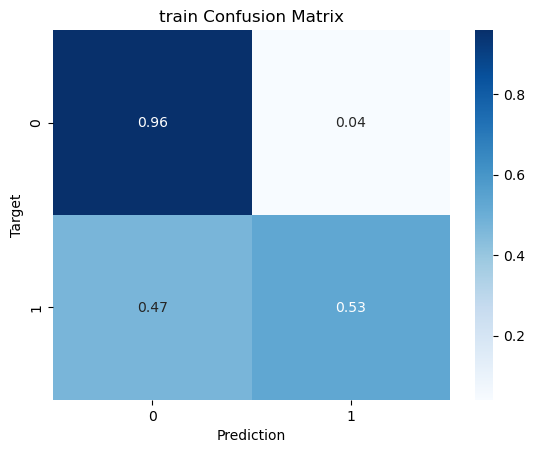

Area under ROC score on val dataset: 0.89%


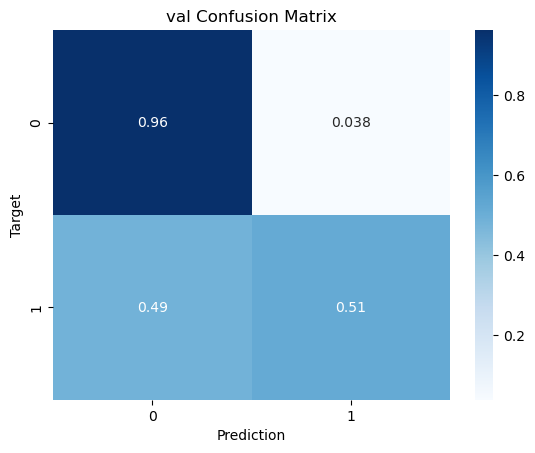

['../Competition/model_pipeline.pkl']

In [161]:
df = pd.read_csv('../Competition/train.csv')
df_test = pd.read_csv('../Competition/test.csv')
target_col = 'Exited'

df.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True)
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['Exited']), df['Exited'], test_size=0.2, random_state=12)
numeric_cols = X_train.select_dtypes(include='number').columns
categorical_cols = X_train.select_dtypes(include='object').columns
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=12))
])

# Тренуємо пайплайн
model_pipeline.fit(X_train, y_train)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, model_pipeline.predict_proba(inputs)[:, 1])
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, X_train, y_train, name='train')
val_preds = predict_and_plot(model_pipeline, X_val, y_val, name='val')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, '../Competition/model_pipeline.pkl')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on train poly dataset: 0.92%


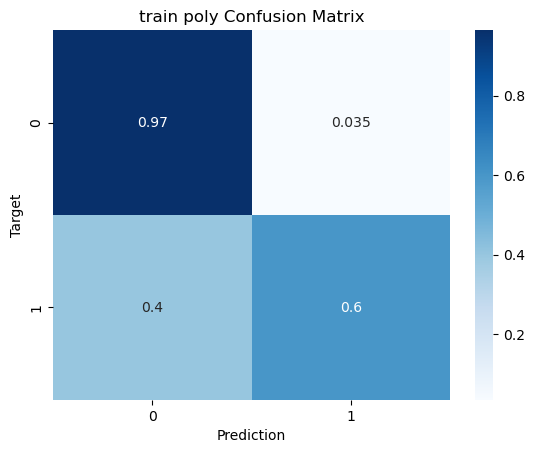

Area under ROC score on val poly dataset: 0.92%


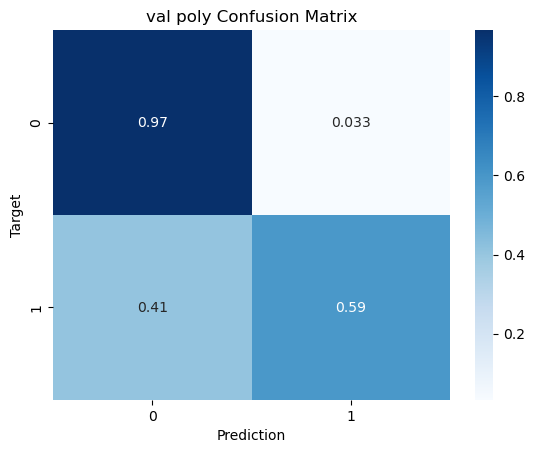

['../Competition/model_pipeline_poly.pkl']

In [162]:
numeric_transformer_poly = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])


preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(max_iter=2000, random_state=12))
])
# Тренуємо пайплайн
model_pipeline_poly.fit(X_train, y_train)

train_preds = predict_and_plot(model_pipeline_poly, X_train, y_train, name='train poly')
val_preds = predict_and_plot(model_pipeline_poly, X_val, y_val, name='val poly')

joblib.dump(model_pipeline_poly, '../Competition/model_pipeline_poly.pkl')

In [163]:
feature_names = model_pipeline_poly.named_steps['preprocessor'].get_feature_names_out()
print(feature_names)

['num__CreditScore' 'num__Age' 'num__Tenure' 'num__Balance'
 'num__NumOfProducts' 'num__HasCrCard' 'num__IsActiveMember'
 'num__EstimatedSalary' 'num__CreditScore^2' 'num__CreditScore Age'
 'num__CreditScore Tenure' 'num__CreditScore Balance'
 'num__CreditScore NumOfProducts' 'num__CreditScore HasCrCard'
 'num__CreditScore IsActiveMember' 'num__CreditScore EstimatedSalary'
 'num__Age^2' 'num__Age Tenure' 'num__Age Balance'
 'num__Age NumOfProducts' 'num__Age HasCrCard' 'num__Age IsActiveMember'
 'num__Age EstimatedSalary' 'num__Tenure^2' 'num__Tenure Balance'
 'num__Tenure NumOfProducts' 'num__Tenure HasCrCard'
 'num__Tenure IsActiveMember' 'num__Tenure EstimatedSalary'
 'num__Balance^2' 'num__Balance NumOfProducts' 'num__Balance HasCrCard'
 'num__Balance IsActiveMember' 'num__Balance EstimatedSalary'
 'num__NumOfProducts^2' 'num__NumOfProducts HasCrCard'
 'num__NumOfProducts IsActiveMember' 'num__NumOfProducts EstimatedSalary'
 'num__HasCrCard^2' 'num__HasCrCard IsActiveMember'
 'num_

Модель добре генералізую так як  AUC я на тренувальних так і валідаційних даних хороший

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on train poly 4 dataset: 0.93%


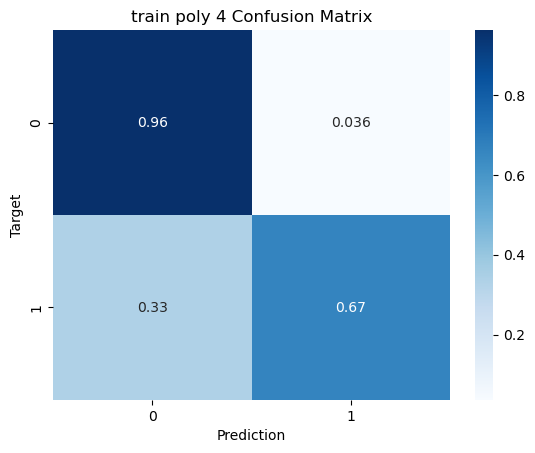

Area under ROC score on val poly 4 dataset: 0.93%


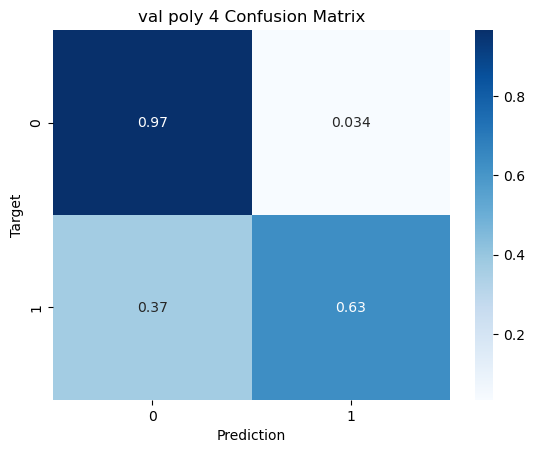

In [164]:
numeric_transformer_poly_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4, include_bias=False))
])


preprocessor_poly_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model_pipeline_poly_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_4),
    ('classifier', LogisticRegression(max_iter=2000, random_state=12))
])
# Тренуємо пайплайн
model_pipeline_poly_4.fit(X_train, y_train)

train_preds = predict_and_plot(model_pipeline_poly_4, X_train, y_train, name='train poly 4')
val_preds = predict_and_plot(model_pipeline_poly_4, X_val, y_val, name='val poly 4')

test_probs = model_pipeline_poly.predict_proba(df_test)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],   
    'Exited': test_probs.round(4)
})

submission.to_csv('submission.csv', index=False)


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [165]:
df_reg = pd.read_csv('regression_data.csv')
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(df_reg.drop(columns=['target']), df_reg['target'], test_size=0.2, random_state=12)
numeric_cols_reg = X_train_reg.select_dtypes(include='number').columns

numeric_transformer_poly_5 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=5, include_bias=False))
])


preprocessor_poly_5 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_5, numeric_cols_reg)
    ]
)

model_pipeline_poly_5 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_5),
    ('classifier', LinearRegression())
])
model_pipeline_poly_5.fit(X_train_reg, y_train_reg)

y_train_pred = model_pipeline_poly_5.predict(X_train_reg)
y_val_pred = model_pipeline_poly_5.predict(X_val_reg)

print("Train R2:", r2_score(y_train_reg, y_train_pred))
print("Val R2:", r2_score(y_val_reg, y_val_pred))

print("Train MSE:", mean_squared_error(y_train_reg, y_train_pred))
print("Val MSE:", mean_squared_error(y_val_reg, y_val_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train_reg, y_train_pred)))
print("RMSE:", np.sqrt(mean_squared_error(y_val_reg, y_val_pred)))

Train R2: 1.0
Val R2: 0.8065626553242484
Train MSE: 6.089380472739595e-26
Val MSE: 511.2287875913962
Train RMSE: 2.467667010100754e-13
RMSE: 22.61036902820023


вже спостерігається перенавчання

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [166]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet


numeric_transformer_poly_20 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=20, include_bias=False))
])

preprocessor_poly_20 = ColumnTransformer([
    ('num', numeric_transformer_poly_20, numeric_cols_reg)
])
# Lasso
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor_poly_20),
    ('regressor', Lasso(alpha=0.1, max_iter=5000, random_state=12))
])

# Ridge
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor_poly_20),
    ('regressor', Ridge(alpha=1.0))
])

# ElasticNet
elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor_poly_20),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000, random_state=12))
])
models = {
    'Lasso': lasso_pipeline,
    'Ridge': ridge_pipeline,
    'ElasticNet': elastic_pipeline
}
for name, model in models.items():
    model.fit(X_train_reg, y_train_reg)
    y_train_pred = model.predict(X_train_reg)
    y_val_pred = model.predict(X_val_reg)
    print(f"Model: {name}")
    print("Train R2:", r2_score(y_train_reg, y_train_pred))
    print("Val R2:", r2_score(y_val_reg, y_val_pred))
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train_reg, y_train_pred)))
    print("Val RMSE:", np.sqrt(mean_squared_error(y_val_reg, y_val_pred)))
    print("Coef length:", np.sum(model.named_steps['regressor'].coef_ != 0))

Model: Lasso
Train R2: 0.9993142115391728
Val R2: 0.9992512134920144
Train RMSE: 1.1408425285983548
Val RMSE: 1.4067486104814477
Coef length: 1
Model: Ridge
Train R2: 0.9817880628747726
Val R2: 0.41673079128079316
Train RMSE: 5.879070755415328
Val RMSE: 39.26196347944355
Coef length: 53129
Model: ElasticNet
Train R2: 0.927134098699631
Val R2: 0.7142210439094684
Train RMSE: 11.75960641464739
Val RMSE: 27.482270653612037
Coef length: 365


Ласо модель виявилась найкращою, залишивши лише одну фічу